In [1]:
#! pip install folium bokeh
#!pip install autogluon
!pip install holidays
!pip install bokeh
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from functools import wraps
import time
import os
import seaborn as sns
from utils import *
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from datetime import datetime
from datetime import date
import holidays
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from sklearn.model_selection import train_test_split
from sklearn. multioutput import MultiOutputRegressor


In [2]:
def load_data(names):
    dataframes = []
    for path in [f'{x}.parquet' for x in names]:
        if not os.path.exists(path):  # Check if the file exists
            return False
        try:
            df = pd.read_parquet(path)  # Attempt to load the DataFrame
            dataframes.append(df)
        except Exception as e:  # Catch any error (e.g., file corrupted or read error)
            print(f"Error loading {path}: {e}")
            return False
    return tuple(dataframes)

def save_data(dataframes, names):
    for dataframe, name in zip(dataframes, names):
        dataframe.to_parquet(f'{name}.parquet')

In [3]:
dataframe_names = ['X_train', 'Y_train', 'R_train']
data = load_data(dataframe_names)
X, Y, R = data[0], data[1], data[2]
YR = Y.to_numpy()-R.to_numpy()

horizon = 960
YR = YR[:, :horizon]

In [4]:
x_column_subset1 = [x for x in X.columns if ('lag' in x and int(x.split('_')[1])>-500) or 'lag' not in x]
X = X[x_column_subset1]
x_column_subset2 = [x for x in X.columns if ('ma' in x and int(x.split('_')[1])>-500) or 'ma' not in x]
X = X[x_column_subset2]
x_column_subset3 = [x for x in X.columns if ('holiday' in x and int(x.split('_')[1])<=horizon) or 'holiday' not in x]
X = X[x_column_subset3]
x_column_subset4 = [x for x in X.columns if ('r_' in x and int(x.split('_')[1])<=horizon) or 'r_' not in x]
X = X[x_column_subset4]

In [5]:
#x_column_subset2

In [6]:
YR.shape

(20000, 960)

In [7]:
X.columns

Index(['lag_-499', 'lag_-498', 'lag_-497', 'lag_-496', 'lag_-495', 'lag_-494',
       'lag_-493', 'lag_-492', 'lag_-491', 'lag_-490',
       ...
       'holiday_+951', 'holiday_+952', 'holiday_+953', 'holiday_+954',
       'holiday_+955', 'holiday_+956', 'holiday_+957', 'holiday_+958',
       'holiday_+959', 'holiday_+960'],
      dtype='object', length=2922)

In [8]:
X.shape

(20000, 2922)

In [9]:
#from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
#sc = StandardScaler()
#sc.fit(X)
#X_train_std = sc.transform(X)
#pca = PCA()
##
## Determine transformed features
##
#X_train_pca = pca.fit_transform(X_train_std)
##
## Determine explained variance using explained_variance_ration_ attribute
##
#exp_var_pca = pca.explained_variance_ratio_
##
## Cumulative sum of eigenvalues; This will be used to create step plot
## for visualizing the variance explained by each principal component.
##
#cum_sum_eigenvalues = np.cumsum(exp_var_pca)
##
## Create the visualization plot
##
#plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
#plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
#plt.ylabel('Explained variance ratio')
#plt.xlabel('Principal component index')
#plt.legend(loc='best')
#plt.tight_layout()
#plt.show()

In [10]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, YR, test_size=0.2, random_state=42)

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor 
#cb = MultiOutputRegressor(CatBoostRegressor(loss_function='MAE', 
#                       verbose=True, 
#                       random_seed=42, subsample=0.05), n_jobs=-1)
cb = RandomForestRegressor(criterion='squared_error', n_jobs=-1, random_state=42, verbose=5)

#cb = Pipeline([
#    ('scaler', StandardScaler()),
#    ('pca', PCA(n_components=0.95)),
#    ('random_forest', RandomForestRegressor(criterion='squared_error', n_jobs=-1, random_state=42, verbose=5, max_samples=0.25))
#])

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import SGDRegressor

# Define the pipeline
cb = Pipeline([
    #('scaler', StandardScaler()),
    #('pca', PCA(n_components=0.9)),
    ('extra_trees', ExtraTreesRegressor(criterion='squared_error', n_jobs=50, random_state=42, verbose=5, max_samples=1.0, bootstrap=True))
])

#cb = Pipeline([
#    ('scaler', StandardScaler()),
#    ('pca', PCA(n_components=0.90)),
#    ('sgd_regressor', SGDRegressor(loss='epsilon_insensitive', epsilon=0.01, max_iter=1000, tol=1e-3, random_state=42, verbose=5))
#])

# Fit the model
cb.fit(X_train, Y_train)

[Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=50)]: Done  22 out of 100 | elapsed:  6.0min remaining: 21.4min


building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=50)]: Done  43 out of 100 | elapsed:  6.6min remaining:  8.7min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=50)]: Done  64 out of 100 | elapsed: 10.7min remaining:  6.0min
[Parallel(n_jobs=50)]: Done  85 out of 100 | elapsed: 12.1min remaining:  2.1min
[Parallel(n_jobs=50)]: Done 100 out of 100 | elapsed: 12.4min finished


Pipeline(steps=[('extra_trees',
                 ExtraTreesRegressor(bootstrap=True, max_samples=1.0, n_jobs=50,
                                     random_state=42, verbose=5))])

In [13]:

# Predict on the test set
Y_pred_cb = cb.predict(X_test)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_test, Y_pred_cb)

print(f"The Mean Absolute Error (MAE) on the test set is: {mae}")

[Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done  22 out of 100 | elapsed:    0.5s remaining:    1.7s
[Parallel(n_jobs=50)]: Done  43 out of 100 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=50)]: Done  64 out of 100 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=50)]: Done  85 out of 100 | elapsed:    1.0s remaining:    0.2s


The Mean Absolute Error (MAE) on the test set is: 0.9935456875000044


[Parallel(n_jobs=50)]: Done 100 out of 100 | elapsed:    1.1s finished


In [14]:
#from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import mean_squared_error
#from sklearn.ensemble import HistGradientBoostingRegressor
#import xgboost as xgb
#from sklearn.neural_network import MLPRegressor
#from sklearn.linear_model import SGDRegressor

#rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=True, max_samples=0.2, criterion='absolute_error')
#rf.fit(X_train, Y_train)
#Y_pred = rf.predict(X_test)
#mae = mean_squared_error(Y_test, Y_pred)

#print(f"The Mean Absolute Error (MAE) on the test set is: {mae}")

In [15]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y.to_numpy()-R.to_numpy(), test_size=0.2, random_state=42)
#rf = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
#rf.fit(X_train, Y_train)
#Y_pred = rf.predict(X_test)
#mae = mean_squared_error(Y_test, Y_pred)
#
#print(f"The Mean Absolute Error (MAE) on the test set is: {mae}")

In [16]:
#from autogluon.tabular.experimental._tabular_regressor import TabularRegressor
#from sklearn. multioutput import MultiOutputRegressor
#
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y.to_numpy()-R.to_numpy(), test_size=0.2, random_state=42)
#auto = MultiOutputRegressor(TabularRegressor(eval_metric='mae', time_limit=120, verbosity=0), n_jobs=5)
#auto.fit(X_train, Y_train)
#Y_pred = auto.predict(X_test)
#mae = mean_squared_error(Y_test, Y_pred)
#
#print(f"The Mean Absolute Error (MAE) on the test set is: {mae}")

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

dummy_mean = DummyRegressor(strategy="mean")
dummy_mean.fit(X_train, Y_train)
Y_pred_m = dummy_mean.predict(X_test)
mae = mean_absolute_error(Y_test, Y_pred_m)

print(f"The Mean Absolute Error (MAE) on the test set is: {mae}")

The Mean Absolute Error (MAE) on the test set is: 1.494070236686198


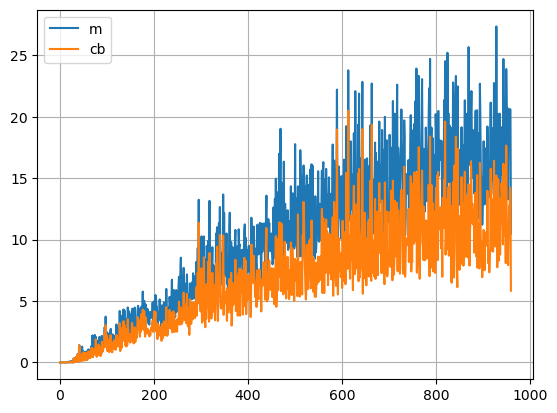

In [18]:

plt.plot(((Y_pred_m-Y_test)**2).mean(axis=0), label='m')
plt.plot(((Y_pred_cb-Y_test)**2).mean(axis=0), label='cb')
plt.legend()
plt.grid()

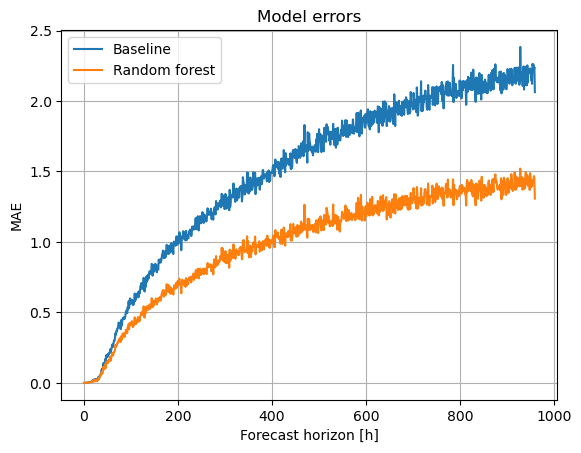

In [19]:
plt.plot(np.mean((np.abs((Y_pred_m-Y_test))), axis=0), label='Baseline')
plt.plot(np.mean((np.abs(Y_pred_cb-Y_test)), axis=0), label='Random forest')
plt.plot()
plt.legend()
plt.grid()
plt.title('Model errors')
plt.xlabel('Forecast horizon [h]')
plt.ylabel('MAE')
plt.savefig('model_errors.pdf', bbox_inches='tight')

In [20]:
#erte=ereg

In [21]:
#from autogluon.tabular.experimental._tabular_regressor import TabularRegressor
#from sklearn. multioutput import MultiOutputRegressor

#auto = TabularRegressor(eval_metric='mae', time_limit=500, verbosity=2, presets='high_quality')
#auto.fit(X_train.to_numpy(), Y_train)
#Y_pred = auto.predict(X_test.to_numpy())
#mae = mean_squared_error(Y_test, Y_pred)

#print(f"The Mean Absolute Error (MAE) on the test set is: {mae}")

In [22]:
dataframe_names = ['X_test', 'Y_test', 'R_test']
data = load_data(dataframe_names)
X, Y, R = data[0], data[1], data[2]
YR = Y.to_numpy()-R.to_numpy()
YR = YR[:, :horizon]

In [23]:
x_column_subset1 = [x for x in X.columns if ('lag' in x and int(x.split('_')[1])>-500) or 'lag' not in x]
X = X[x_column_subset1]
x_column_subset2 = [x for x in X.columns if ('ma' in x and int(x.split('_')[1])>-500) or 'ma' not in x]
X = X[x_column_subset2]
x_column_subset3 = [x for x in X.columns if ('holiday' in x and int(x.split('_')[1])<=horizon) or 'holiday' not in x]
X = X[x_column_subset3]
x_column_subset4 = [x for x in X.columns if ('r_' in x and int(x.split('_')[1])<=horizon) or 'r_' not in x]
X = X[x_column_subset4]

In [24]:
pred_cb = cb.predict(X)
mae = mean_squared_error(pred_cb, YR)
print(f"The Mean Absolute Error (MAE) on the test set is: {mae}")
v1 = np.abs(pred_cb-YR).mean(axis=0)

[Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done  22 out of 100 | elapsed:    0.4s remaining:    1.4s
[Parallel(n_jobs=50)]: Done  43 out of 100 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=50)]: Done  64 out of 100 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=50)]: Done  85 out of 100 | elapsed:    1.0s remaining:    0.2s


The Mean Absolute Error (MAE) on the test set is: 6.454475506812469


[Parallel(n_jobs=50)]: Done 100 out of 100 | elapsed:    1.1s finished


(5000, 960)


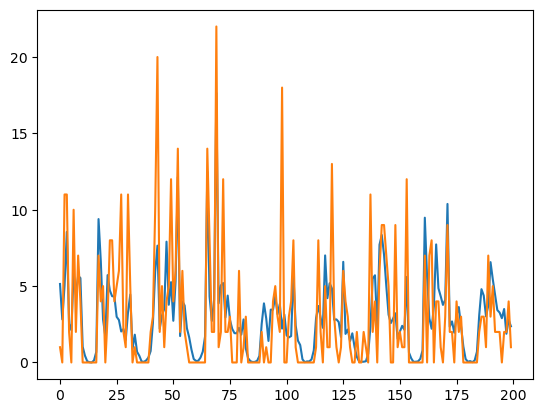

In [25]:
forecast_cb = (pred_cb+R.to_numpy()[:, :horizon])
truth = Y.to_numpy()[:, :horizon]
res = R.to_numpy()[:, :horizon]

instance = 0
print(forecast_cb.shape)
#print(forecast.shape)
plt.plot(forecast_cb[instance, (horizon-200):horizon])
plt.plot(truth[instance, (horizon-200):horizon])

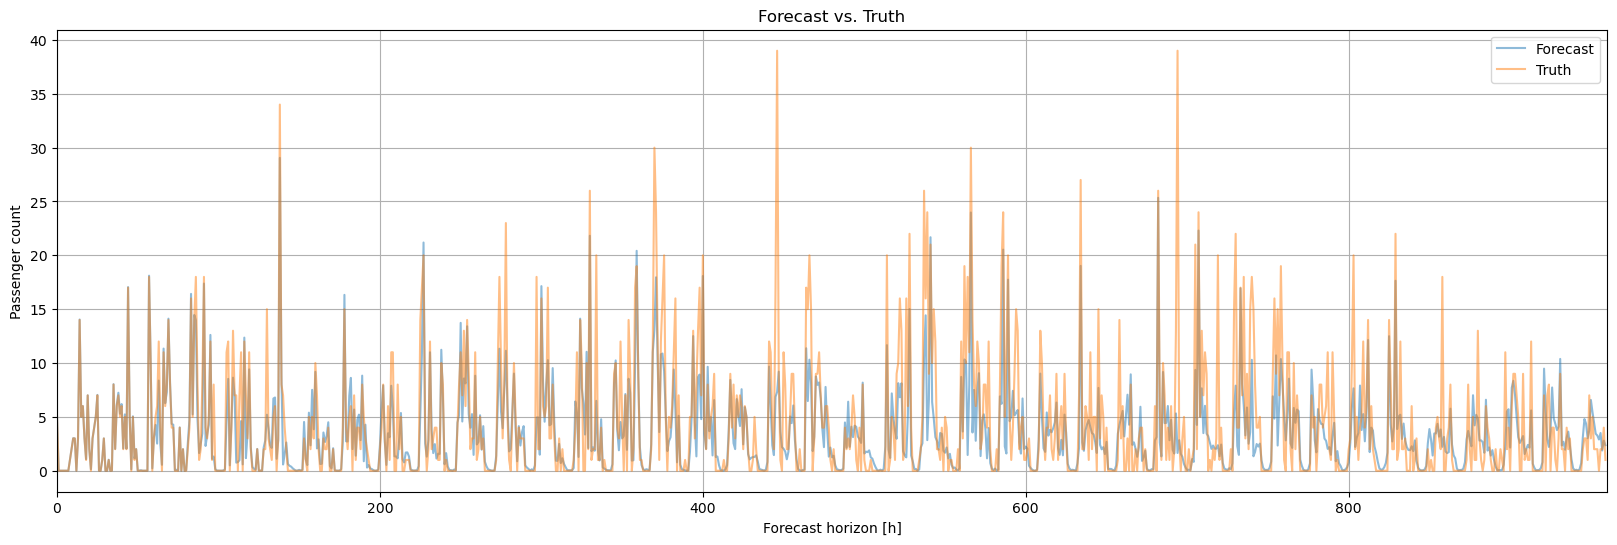

In [36]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(20, 6))

# Plotting the forecast with a transparency of 0.5
plt.plot(forecast_cb[0, :], alpha=0.5)

# Plotting the truth data with a transparency of 0.5
plt.plot(truth[0, :], alpha=0.5)

# Optionally, add titles, labels, etc.
plt.title('Forecast vs. Truth')
plt.xlabel('Forecast horizon [h]')
plt.ylabel('Passenger count')
plt.legend(['Forecast', 'Truth'])
plt.grid()
plt.xlim([0, horizon])

# Save the plot to a file with a tight layout
plt.savefig('forecast_vs_truth.pdf', bbox_inches='tight')

In [27]:
#plt.plot(Y.to_numpy()[:, (horizon-200):horizon][0, :])

In [28]:
#v1 = X[[x for x in X.columns if 'lag' in x]].iloc[0]
#plt.plot(v1)
#plt.plot(v2)

In [29]:
pred_m = dummy_mean.predict(X)
mae = mean_squared_error(pred_m, YR)
print(f"The Mean Absolute Error (MAE) on the test set is: {mae}")
v2 = np.abs(pred_m-YR).mean(axis=0)

The Mean Absolute Error (MAE) on the test set is: 7.55555375310382


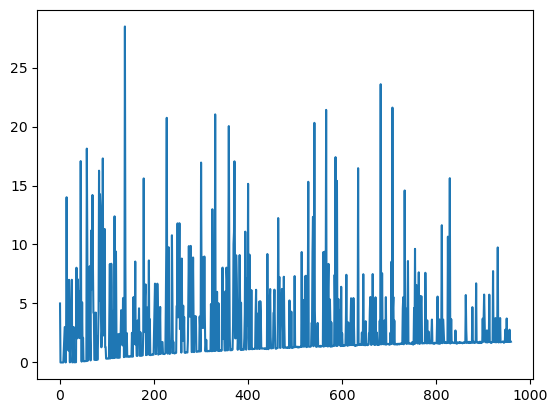

In [30]:
#plt.plot(v1)
#plt.plot(v2)
plt.plot((pred_m+R.to_numpy()[:, :horizon])[0, :])

In [31]:
#mae = mean_squared_error(auto.predict(X), YR)
#print(f"The Mean Absolute Error (MAE) on the test set is: {mae}")

In [32]:
#dataframe_names = ['X_test', 'Y_test', 'R_test']
#data = load_data(dataframe_names)
#if data == False:
#    start = pd.to_datetime('2022-01-01')
#    end = pd.to_datetime('2022-12-31')
#    
#    random_dates = pd.to_datetime(np.random.uniform(start.value, end.value, 5000), unit='ns')
#    
#    pool = Pool(20)
#    results = list(tqdm(pool.imap(process_date, random_dates), total=len(random_dates)))
#    pool.close()
#    pool.join()
#    
#    X, Y, R = [], [], []
#    
#    # Unpack results
#    for x, y, r in results:
#        X.append(x)
#        Y.append(y)
#        R.append(r)
#    
#    X = pd.concat(X)
#    Y = pd.concat(Y)
#    R = pd.concat(R)
#    
#    save_data([X, Y, R], dataframe_names)
#else:
#    X, Y, R = data[0], data[1], data[2]
#
#print(X.shape, Y.shape, R.shape)

In [33]:
#Y_pred = rf.predict(X)
#mae = mean_squared_error(Y, Y_pred+R.to_numpy())
#print(f"The Mean Absolute Error (MAE) on the test set is: {mae}")

In [34]:
#wfsf=Sdfsf

In [35]:
errors = {}

for index, row in tqdm(list((Y-(Y_pred+R.to_numpy())).iterrows())):
    ts = index.ceil(f'{forecaster.round_hours}h')
    for lag in range(0, Y.shape[1]):
        lag_timestamp = ts + lag * pd.Timedelta(hours=3)
        if lag_timestamp not in errors:
            errors[lag_timestamp] = []
        errors[lag_timestamp].append(row.iloc[lag])

NameError: name 'Y_pred' is not defined

In [ ]:
v = sorted([(k, np.mean(v)) for k, v in errors.items()])
dates = [x[0] for x in v]
values = [x[1] for x in v]

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Assuming 'dates' and 'values' are already defined as in your example
# Convert to DataFrame for easier manipulation
df = pd.DataFrame({'Date': dates, 'Value': values})
df.set_index('Date', inplace=True)

# Compute the moving average with a window size, e.g., 3 for a 3-point moving average
window_size = 21
df['MovingAverage'] = df['Value'].rolling(window=window_size).mean()

# Plotting
plt.figure(figsize=(10, 6))

# Plot original values
plt.plot(df.index, df['Value'], label='Original Values', color='b')

# Plot moving average
plt.plot(df.index, df['MovingAverage'], label='Moving Average', color='r')

plt.title('Error of the model over time')  # Title of the plot
plt.xlabel('Date')  # X-axis label
plt.ylabel('Value')  # Y-axis label
plt.xticks(rotation=90)  # Rotate date labels for better readability
plt.legend()  # Show legend
plt.tight_layout()  # Adjust layout
plt.grid()  # Show grid
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist((Y-(Y_pred+R.to_numpy())).to_numpy().flatten(), bins=30, alpha=0.75, color='blue', edgecolor='black')
plt.title('Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
i=11
plt.figure(figsize=(26, 6))
plt.plot(Y.iloc[i].to_list(), label='true', linewidth=3)
plt.plot((Y_pred+R.to_numpy())[i, :], label='pred')
plt.xlabel('horizon (3h buckets)')
plt.ylabel('passengers')
plt.legend()

In [ ]:
plt.plot((Y-(Y_pred+R.to_numpy())).abs().mean(axis=0).to_list())
plt.xlabel('horizon (3h buckets)')
plt.ylabel('MAE')
plt.grid()

In [ ]:
plt.plot((Y-(Y_pred+R.to_numpy())).mean(axis=0).to_list())
plt.xlabel('horizon (3h buckets)')
plt.ylabel('MAE')
plt.grid()

In [ ]:
Y_pred = dummy_mean.predict(X)
mae = mean_squared_error(Y, Y_pred+R.to_numpy())
print(f"The Mean Absolute Error (MAE) on the test set is: {mae}")

In [ ]:
i=12
plt.figure(figsize=(26, 6))
plt.plot(Y.iloc[i].to_list(), label='true', linewidth=3)
plt.plot((Y_pred+R.to_numpy())[i, :], label='pred')
plt.xlabel('horizon (3h buckets)')
plt.ylabel('passengers')
plt.legend()

In [ ]:
plt.plot((Y-(Y_pred+R.to_numpy())).abs().mean(axis=0).to_list())
plt.xlabel('horizon (3h buckets)')
plt.ylabel('MAE')
plt.grid()

In [ ]:
Y_pred = R.to_numpy()
mae = mean_squared_error(Y, R.to_numpy())
print(f"The Mean Absolute Error (MAE) on the test set is: {mae}")

In [ ]:
i=12
plt.figure(figsize=(26, 6))
plt.plot(Y.iloc[i].to_list(), label='true', linewidth=3)
plt.plot((R.to_numpy())[i, :], label='pred')
plt.xlabel('horizon (3h buckets)')
plt.ylabel('passengers')
plt.legend()

In [ ]:
plt.plot((Y-R.to_numpy()).abs().mean(axis=0).to_list())
plt.xlabel('horizon (3h buckets)')
plt.ylabel('MAE')
plt.grid()

In [ ]:
forest_importances = pd.Series(rf.feature_importances_, index=list(X.columns)).sort_values().tail(80)
fig, ax = plt.subplots(figsize=(5, 10))  # Increased figure height
forest_importances.plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()